In [1]:
#import modules
import csv
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import pyregion
from scipy import integrate
from scipy import ndimage
from scipy.interpolate import BSpline
from scipy.interpolate import interp1d
from scipy.interpolate import spline
from scipy.optimize import curve_fit
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

In [2]:
#edit these, along with fitting box size in CMD
prefix ='CENA-132302'
binning=16

In [3]:
band1 ='F606W'
band2 ='F814W'

#read in files and create pandas dataframes with header names from first row
photometryFile = "%s.phot2" % prefix
completenessFile = "%s.phot.fake2" % prefix
photDF = pd.read_csv(photometryFile, delim_whitespace=True, header=0) 
completeDF = pd.read_csv(completenessFile, delim_whitespace=True, header=0) 

#spatial selection on photDF- performed using ds9 region
regionName = "%s.reg" %prefix
regionFile = pyregion.open(regionName)

#create polygon from ds9 region file
numPolyPoints = int(len(regionFile[0].coord_list)/2)
PolygonList = []
i=0
j=0
while i < numPolyPoints:
    PolygonList.append((int(regionFile[0].coord_list[j]), int(regionFile[0].coord_list[j+1])))
    i = i + 1
    j = j + 2
RegionPolygon = Polygon(PolygonList)

#create a column where 0 means that star is not in region, 1 means it is
photDF['Point'] = 0
for i in range(len(photDF['x'])):
    photDF['Point'][i] = RegionPolygon.contains(Point(photDF['x'][i], photDF['y'][i]))
    
#limit data frame to only those places where star is in selected ds9 region
photDF = photDF[(photDF['Point'] > 0)]

#rename completeDF columns to match other script (for ease)
completeDF.columns = ['stV', 'stI', 'fakeV', 'fakeI', 'fakeVerr', 'fakeIerr']

/Users/Deep/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
#show first three rows of photDF
# photDF[0:3]

In [5]:
#set 99.999 values to nan values in fakeV and fakeI of completeDF
completeDF.loc[completeDF.fakeV == 99.999, 'fakeV'] = np.nan
completeDF.loc[completeDF.fakeI == 99.999, 'fakeI'] = np.nan
completeDF[13:19]

#convert to numpy arrays for ease of math
stV = completeDF.stV.values
stI = completeDF.stI.values
fakeV   = completeDF.fakeV.values
fakeI   = completeDF.fakeI.values
fakeVerr   = completeDF.fakeVerr.values
fakeIerr   = completeDF.fakeIerr.values

#also convert some for real photometry file
realV = photDF.mag_V
realVErr = photDF.Verr
realI = photDF.mag_I
realIErr = photDF.Ierr

#additional selection criteria for fake photometry
#SHOULD LAST TWO BE FAKEIERR INSTEAD?
fakeSelectionParameter = 0.3
stV_sel = stV[np.logical_and(fakeVerr < fakeSelectionParameter, fakeV != np.nan)]
fakeV_sel   = fakeV[np.logical_and(fakeVerr < fakeSelectionParameter, fakeV != np.nan)]
stI_sel = stI[np.logical_and(fakeVerr < fakeSelectionParameter, fakeI != np.nan)]
fakeI_sel   = fakeI[np.logical_and(fakeVerr < fakeSelectionParameter, fakeI != np.nan)]

In [6]:
#define GetSmoothedStats
def GetSmoothedStats(Xall,X,Y):
    medx = np.median(X)
    w=np.median([abs(x-medx) for x in X])/0.6745
    w=w*(4/(3*len(X)))**(1/5)
    w=max(w/4,0.005)
    xi = np.linspace(min(X),max(X),binning)
    xi=np.append(xi,np.max(xi)+0.5*w)
    xi=np.append(xi,np.max(xi)+w)

    dX=Y-X
    nall = np.zeros(len(xi))
    n = nall.copy()
    b = nall.copy()
    s = nall.copy()
    for k in range(len(xi)):
        nall[k]=np.sum(np.e**(-0.5*((xi[k]-Xall)/w)**2))/(w*np.sqrt(2*np.pi))
        p = np.e**(-0.5*((xi[k]-X)/w)**2) / (w*np.sqrt(2*np.pi))
        n[k]   =np.sum(np.e**(-0.5*((xi[k]-X   )/w)**2))/(w*np.sqrt(2*np.pi))
        b[k]=np.sum(dX*p) / n[k]
        s[k]=np.sqrt(np.sum(dX**2*p)/n[k]-b[k]**2)
        if n[k]>=2:
            s[k]=s[k]*np.sqrt(n[k]/(n[k]-1))
    
    c=n.copy()/nall.copy()
    ind = np.logical_and(np.isfinite(c),np.isfinite(b),np.isfinite(s))
    c=c[ind]
    b=b[ind]
    s=s[ind]
    xi=xi[ind]
    return xi,c,b,s

In [7]:
#calculate 4th order coefficients to be used in error, completeness, and bias functions
deg=4
mag_V,complet_V,bias_V,errors_V = GetSmoothedStats(stV,stV_sel,fakeV_sel)
mag_I,complet_I,bias_I,errors_I = GetSmoothedStats(stI,stI_sel,fakeI_sel)
centerCoef = np.polyfit(mag_I, bias_I, deg=deg)
errCoef = np.polyfit(mag_I, errors_I, deg=deg)
compltCoef = np.polyfit(mag_I,complet_I, deg=deg)

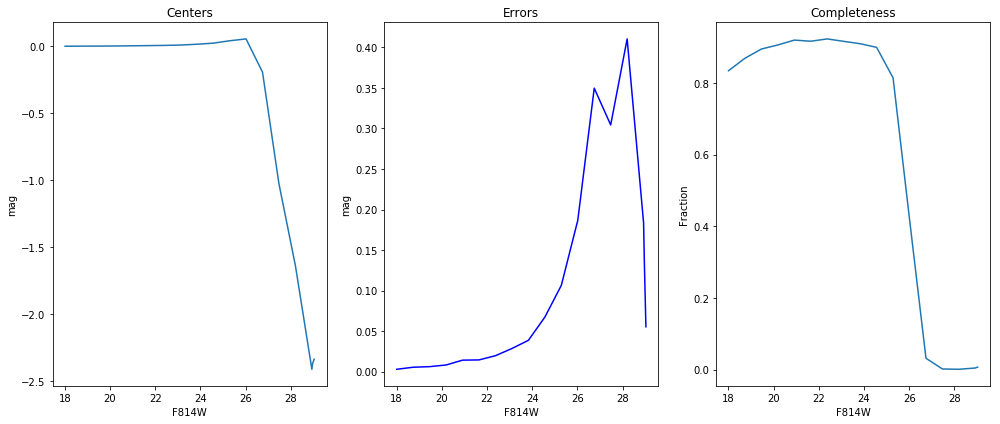

In [8]:
#create plots of error, completeness, and bias functions
fig = plt.figure(figsize=(14,6))

PLTCenters = fig.add_subplot(131)
PLTCenters.plot(mag_I,bias_I)
PLTCenters.set_xlabel(band2)
PLTCenters.set_ylabel("mag")
PLTCenters.set_title("Centers")
        
PLTErrors= fig.add_subplot(132)
PLTErrors.plot(mag_I,errors_I,color='blue')
PLTErrors.set_xlabel(band2)
PLTErrors.set_ylabel("mag")
PLTErrors.set_title("Errors")

Completeness = fig.add_subplot(133)
Completeness.plot(mag_I,complet_I)
Completeness.set_xlabel(band2)
Completeness.set_ylabel("Fraction")
Completeness.set_title("Completeness")

fig.tight_layout()
plt.savefig('%sfunctions.ps' %prefix, dpi=300)

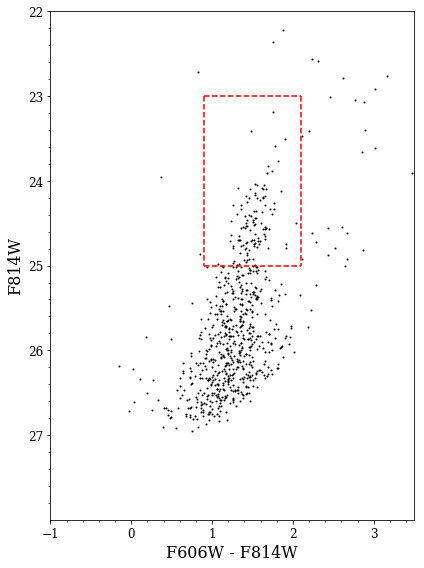

In [9]:
#CMD with boxed region
plt.rc('font',family='serif')
plt.rc('xtick',labelsize='12')
plt.rc('ytick',labelsize='12')
cmd = plt.figure(figsize=(6,8))
ax = cmd.add_subplot(1,1,1)
ax.plot(realV-realI, realI,'o',markersize=1, color='black')

PLT ={'cl' : 0.9, 'ch' : 2.1, 'ml' : 23.0, 'mh' : 25.0}

ax.plot( [ PLT['cl'], PLT['cl']], [PLT['ml'], PLT['mh'] ] , '--', color='red')
ax.plot( [ PLT['ch'], PLT['ch']], [PLT['ml'], PLT['mh'] ] , '--', color='red')
ax.plot( [ PLT['cl'], PLT['ch']], [PLT['ml'], PLT['ml'] ] , '--', color='red')
ax.plot( [ PLT['cl'], PLT['ch']], [PLT['mh'], PLT['mh'] ] , '--', color='red')

xMajorTicks = np.arange(-1, 3.5, 1.0)                                              
xMinorTicks = np.arange(-1, 3.5, 0.2)     
yMajorTicks = np.arange(22, 28, 1.0)                                              
yMinorTicks = np.arange(22, 28, 0.2)     

ax.set_xticks(xMajorTicks)                                                       
ax.set_xticks(xMinorTicks, minor=True)                                           
ax.set_yticks(yMajorTicks)                                                       
ax.set_yticks(yMinorTicks, minor=True)   



ax.set_xlabel("%s - %s" %(band1,band2), fontsize=16)
ax.set_ylabel(band2, fontsize=16)
VRange=photDF.mag_V.values
IRange=photDF.mag_I.values
ax.set_xlim((-1,3.5))
ax.set_ylim((28,22))
cmd.tight_layout()
plt.savefig('%scmd.ps' %prefix, dpi=300)

In [10]:
#luminosity function
binsize = 0.1
bin = np.arange( PLT['ml']-0.5, PLT['mh']+0.5, binsize)
magtics = bin[1:] - binsize/2.
LF, binedeges = np.histogram([i for v,i in zip(realV,realI) 
                              if (v-i>=PLT['cl'] 
                                and v-i<=PLT['ch'] 
                                and i>=PLT['ml'] 
                                and i<=PLT['mh'])],bins=bin)

In [11]:
#smoothed luminosity function
m = np.linspace(PLT['ml']-0.5,PLT['mh']+0.5,50)
dm = m[1]-m[0]
smoothLF=np.zeros(len(m))
for k in range(len(smoothLF)):
    smoothLF[k]=np.sum([(1/(np.sqrt(2*np.pi)*sigma)*np.e**(-1.0*((mag-m[k])**2/(2*sigma**2)))) 
                        for mag,sigma in zip(realI,realIErr)])

# calculate integral under the curve
normalization = np.sum(smoothLF)*dm
smoothLF = smoothLF/normalization
total = np.sum(smoothLF)

# reduce normalization
normalization = normalization / (dm*len(m))

# SOBEL FILTERING
LF_sobel = ndimage.sobel(smoothLF)

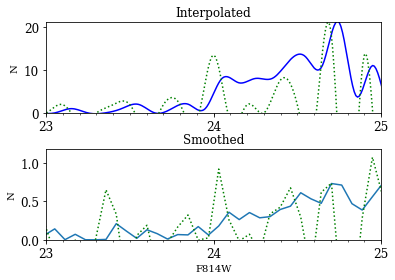

In [12]:
#luminosity function and sobel plot
fig=plt.figure()
LF_prime = np.diff(LF) / binsize
magtics_prime = bin[1:-1]

# smoothed version built by interpolating (spline)
magtics_interp = np.arange(min(bin),max(bin), 0.01)
# LF_interp = interp1d(magtics, LF, kind='cubic')
# LF_prime_interp = interp1d(magtics_prime, LF_prime, kind='cubic')
LF_interp = spline(magtics, LF, magtics_interp)
LF_prime_interp = spline(magtics_prime, LF_prime, magtics_interp)

majorLocator = MultipleLocator(1)
minorLocator = MultipleLocator(0.1)

LFplt = fig.add_subplot(211)
LFplt.plot(magtics_interp,LF_interp,color='blue')
LFplt.set_title("Interpolated")
ymaxLF = np.amax(LF)
ymaxLFprime = np.amax(LF_prime_interp)

# rescale LFPRIME
LF_prime_interp = LF_prime_interp / ymaxLFprime * ymaxLF
LFplt.plot(magtics_interp,LF_prime_interp,':',color='green')
LFprimemax = np.amax(LF_prime_interp)
LFplt.xaxis.set_major_locator(majorLocator)
LFplt.xaxis.set_minor_locator(minorLocator) 
LFplt.set_xlim((PLT['ml'],PLT['mh']))
LFplt.set_ylabel("N")
ymin,ymax = LFplt.get_ylim()
ymax = np.amax(LF)
LFplt.set_ylim((0,ymax))
LFsmoothplt = fig.add_subplot(212)
fig.subplots_adjust(hspace=.4)
LFsmoothplt.plot(m,smoothLF)

# rescale sobel filter
ymaxLF = np.amax(smoothLF)
ymaxsobel = np.amax(LF_sobel)
LF_sobel = LF_sobel/ymaxsobel*ymaxLF
LFsmoothplt.plot(m,LF_sobel,':',color='green')
LFsmoothplt.set_title("Smoothed")
LFsmoothplt.xaxis.set_major_locator(majorLocator)
LFsmoothplt.xaxis.set_minor_locator(minorLocator)
LFsmoothplt.set_xlabel(band2)
LFsmoothplt.set_ylabel("N")
ymin,ymax = LFsmoothplt.get_ylim()
LFsmoothplt.set_xlim((PLT['ml'],PLT['mh']))
LFsmoothplt.set_ylim((0,ymax))
plt.savefig('%slfSmooth.ps' %prefix, dpi=300)

pmagmax = np.amax(realI) #max(x[1] for x in parr)
pmagmin = np.amin(realI) #min(x[1] for x in parr)
fmagmax = np.amax(stV) #max(x[1] for x in farr)
fmagmin = np.amin(stI) #min(x[1] for x in farr)
deg = 4
np.random.seed(0)

In [13]:
#define several needed functions
def idealLF(m,a,b,c,mTRGB):
        if m >= mTRGB:
            return 10**(a*(m-mTRGB)+b)
        else :
            return 10**(c*(m-mTRGB))

def Compltfunc(m):
        return compltCoef[0]*m**4 + compltCoef[1]*m**3 + compltCoef[2]*m**2 + compltCoef[3]*m**1 + compltCoef[4]
        #return 1.0

def mbias(m):
        return centerCoef[0]*m**4 + centerCoef[1]*m**3 + centerCoef[2]*m**2 + centerCoef[3]*m**1 + centerCoef[4]+m
        #return 0.001
def merr(m):
        return errCoef[0]*m**4 + errCoef[1]*m**3 + errCoef[2]*m**2 + errCoef[3]*m**1 + errCoef[4]    
        #return 0.01
def ErrFunc(m, m_prime):
        return (1 / (np.sqrt(2*np.pi)* merr(m_prime) )) * np.e**( - ( m - mbias(m_prime) )**2 / ( 2 * merr(m_prime)**2) )    

def limitFunc(a,b,c,mTRGB):
        " If parameter(s) is out of allowed range, return a big number and add it to LF, preventing fitting procedure choose parameters user doesn't want"
        if a<LIM['al'] or a>LIM['ah'] or b<LIM['bl'] or b>LIM['bh'] or c<LIM['cl'] or c>LIM['ch'] or mTRGB<LIM['mTRGBl'] or mTRGB>LIM['mTRGBh']: return 1.e100
        else: return 0    
    
def realLF(mlist, a, b, c, mTRGB):  
        binsize = mlist[1]-mlist[0]
        print(a,b,c, mTRGB)
        rLF=[]
        for m in mlist:
            rLF.append(integrate.quad(lambda m_prime: idealLF(m_prime,a,b,c,mTRGB)*Compltfunc(m_prime)*ErrFunc(m,m_prime),pmagmin, pmagmax)[0])
            #rLF.append(integrate.quad(lambda m_prime: idealLF(m_prime,a,b,c,mTRGB)*ErrFunc(m,m_prime),pmagmin, pmagmax)[0])
        return np.asarray(rLF)/(sum(rLF)*binsize) + limitFunc(a,b,c,mTRGB)

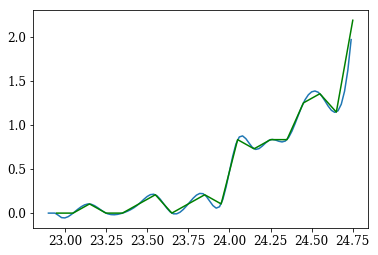

In [14]:
#define arrays for TRGB measurements
INIT  = {'TRGB' : 99, 'a' : 0.3, 'b' : 0.3, 'c' : 0.3 }
LIM   = {'TRGBl' : -99, 'TRGBh' : 99, 'al' : -99, 'ah' : 99, 'bl' : -99, 'bh' : 99, 'cl' : -99, 'ch' : 99 }
RANGE = { 'l' : -1., 'h' : 1. }

#establish fit guesses
INIT['TRGB'] = 23.9
INIT['a'] = 0.25
INIT['b'] = 0.25
INIT['c'] = 0.25

LIM['mTRGBl'] = 22
LIM['mTRGBh'] = 25
LIM['al'] = 0.15
LIM['ah'] = 1.0
LIM['bl'] = 0.15
LIM['bh'] = 0.5
LIM['cl'] = 0.15
LIM['ch'] = 0.5

magnitudes_I=[]
magnitudes_VI=[]
for x in zip(realV,realI):
    if ( x[0]-x[1] >= PLT['cl'] and x[0]-x[1] <= PLT['ch'] ):
        magnitudes_I.append(x[1])
        magnitudes_VI.append([x[0],x[1]])
binsize=0.1
bins = np.arange(INIT['TRGB']+RANGE['l'], INIT['TRGB']+RANGE['h'], binsize)
obsLF, bin_edges = np.histogram(magnitudes_I, bins=bins, density=True)
somma = np.sum(obsLF)
#print(somma)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2.
smoothed_bins = np.arange(min(bin_edges),max(bin_edges)-binsize/2,0.02)
smoothed_obsLF = spline(bin_centers,obsLF,smoothed_bins)
smoothed_obsLF = spline(bin_centers,obsLF,smoothed_bins)
plt.plot(smoothed_bins,smoothed_obsLF)
plt.plot(bin_centers,obsLF,color='green')
#print(np.amax(obsLF))

In [15]:
#TRGB best fit information 
varini=[ INIT['a'], INIT['b'], INIT['c'], INIT['TRGB'] ]
TRGBcolor = [0., 0., 0.,]
BFIT, pcov, info, mesg, ierr = curve_fit(realLF, m, smoothLF, p0=varini,full_output=True)
print("\nBest fit", "TRGB: ",BFIT[3],"\na: ",BFIT[0], "\nb: ",BFIT[1],"\nc: ",BFIT[2])
perr=np.sqrt(np.diag(pcov))

0.25 0.25 0.25 23.9
0.25 0.25 0.25 23.9
0.25 0.25 0.25 23.9
0.250000003725 0.25 0.25 23.9
0.25 0.250000003725 0.25 23.9
0.25 0.25 0.250000003725 23.9
0.25 0.25 0.25 23.9000003561
0.402681504598 0.217295396384 0.644359454692 23.97583384
0.263209586694 0.27416670976 0.282255379029 23.9098496217
0.263209590616 0.27416670976 0.282255379029 23.9098496217
0.263209586694 0.274166713845 0.282255379029 23.9098496217
0.263209586694 0.27416670976 0.282255383235 23.9098496217
0.263209586694 0.27416670976 0.282255379029 23.9098499779
0.290365832162 0.318375309041 0.348633682705 23.9291198012
0.290365836488 0.318375309041 0.348633682705 23.9291198012
0.290365832162 0.318375313785 0.348633682705 23.9291198012
0.290365832162 0.318375309041 0.3486336879 23.9291198012
0.290365832162 0.318375309041 0.348633682705 23.9291201578
0.348814956626 0.380321024152 0.505369040572 23.9544925831
0.296167385335 0.326708002274 0.360356269907 23.9332472323
0.296167389748 0.326708002274 0.360356269907 23.9332472323
0.2

0.25 0.25 0.25 23.9
0.360320754123 0.400553273546 0.499998145176 23.958016853


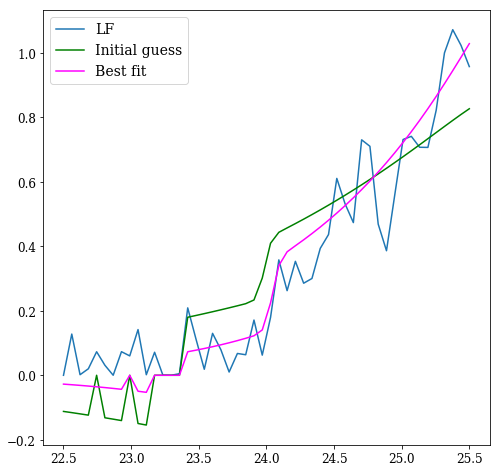

In [16]:
#luminosity function plot
initial_guess = realLF(m,INIT['a'],INIT['b'],INIT['c'],INIT['TRGB'])
calculated_function = realLF(m,a=BFIT[0],b=BFIT[1],c=BFIT[2],mTRGB=BFIT[3])
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)
ax.plot(m,smoothLF, label='LF')
ax.plot(m,initial_guess,color="green", label='Initial guess')
ax.plot(m,calculated_function,color='magenta', label='Best fit')
legend = ax.legend(loc='upper left', fontsize=14)
plt.savefig('%slfFit.ps' %prefix, dpi=300)

In [17]:
#define functions for best fits
def bestidealLF( mlist, a, b, c, mTRGB):
        iLF=[]
        for m in mlist:
            if m >= mTRGB: iLF.append( 10**(a*(m-mTRGB)+b ))
            else: iLF.append( 10**(c*(m-mTRGB)) )
        return np.asarray(iLF)
 
def bestrealLF( mlist, a, b, c, mTRGB):
        rLF=[]
        for m in mlist:
            rLF.append(integrate.quad(lambda m_prime: idealLF(m_prime,a,b,c,mTRGB)*Compltfunc(m_prime)*ErrFunc(m,m_prime),pmagmin, pmagmax)[0])
        return np.asarray(rLF)
    
bestiLF = bestidealLF(m,BFIT[0],BFIT[1],BFIT[2],BFIT[3])
bestrLF = bestrealLF(m,BFIT[0],BFIT[1],BFIT[2],BFIT[3]) 

In [18]:
#TRGB color information
TRGBcolor = [0., 0., 0.,]
Tcolor_list = np.asarray([ x[0]-x[1] for x in magnitudes_VI if (x[1]>BFIT[3] and x[1]<BFIT[3]+0.1)])
nboots = 1000
sample_size = len(Tcolor_list)
me = np.zeros(nboots)
for i in range(nboots):
    sample = Tcolor_list[np.random.randint(0, sample_size, sample_size)]
    me[i] = np.median(sample)
TRGBcolor[0] = np.median(me)
TRGBcolor[1] = np.percentile(me,16)
TRGBcolor[2] = np.percentile(me,84)
#perr = 3*np.sqrt(np.diag(pcov))

#print fit information with errors
color_error = 2*(TRGBcolor[2]-TRGBcolor[0])
print("Best fit")
print("TRGB: ",BFIT[3], " +/- ", perr[3])
print("a: ",BFIT[0], " +/- ", perr[0])
print("b: ",BFIT[1], " +/- ", perr[1])
print("c: ",BFIT[2], " +/- ", perr[2])
print("Color: ", TRGBcolor[0], "+/- ", color_error)

Best fit
TRGB:  23.958016853  +/-  0.0502509615067
a:  0.360320754123  +/-  0.0290971150652
b:  0.400553273546  +/-  0.178967854692
c:  0.499998145176  +/-  0.323035188435
Color:  1.562 +/-  0.152


normalization is 85.8372386207


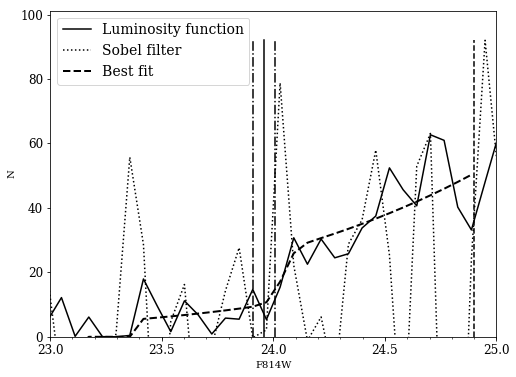

In [19]:
#plot of luminosity function, sobel filter, and best fit
arr_roi=[]
for x in zip(realV,realI):
    if (x[0]-x[1]>=PLT['cl'] and x[0]-x[1]<=PLT['ch'] and x[1]>=INIT['TRGB']+RANGE['l'] and x[1]<=INIT['TRGB']+RANGE['h']):
        arr_roi.append(x)
arr_roi = np.asarray(arr_roi)
fig=plt.figure()


# Scaling fitting result for demonstration #
for i in range(len(m)):
    if m[i] >= BFIT[3]:
        scale_r = (smoothLF[i]+smoothLF[i-1])/(bestrLF[i]+bestrLF[i-1])
        break

pltfittics = []
pltbestrLF = []
for i in range(len(m)-1):
    if m[i] >= INIT['TRGB']+RANGE['l'] and m[i] <= INIT['TRGB']+RANGE['h']:
        pltfittics.append(m[i])
        pltbestrLF.append(bestrLF[i]*scale_r)
#                if bestrLF[i]*scale_r<0.001 : print magtics_smooth[i],bestrLF[i]

lf = plt.figure(figsize=(8,6))
ax = lf.add_subplot(1,1,1)
majorLocator = MultipleLocator(0.5)
minorLocator = MultipleLocator(0.1)
plt.rc('font',family='serif',size=18)
ax.set_xlabel(band2)
ax.set_ylabel("N")
smoothLF_for_plot = smoothLF * normalization
ax.plot(m,smoothLF_for_plot, 'k',color='black', label='Luminosity function')
plt.rc('xtick',labelsize='12')
plt.rc('ytick',labelsize='12')

ax.set_xlim((PLT['ml'],PLT['mh']))
ymax = np.amax(smoothLF_for_plot)
sobel_max = np.amax(LF_sobel)
LF_sobel_for_plot = LF_sobel/sobel_max * ymax
ax.plot(m,LF_sobel_for_plot,':',color='black', label='Sobel filter')
ax.set_ylim((0,ymax+(ymax/10))) 
pltbestrLF_for_plot = [x*normalization for x in pltbestrLF]
ax.plot(pltfittics, pltbestrLF_for_plot, 'k--',color='black', linewidth=2, label='Best fit')
ax.plot([ INIT['TRGB']+RANGE['l'], INIT['TRGB']+RANGE['l'] ], [0,ymax], '--', color='black')
ax.plot([ INIT['TRGB']+RANGE['h'], INIT['TRGB']+RANGE['h'] ], [0,ymax], '--', color='black')
ax.plot([BFIT[3],BFIT[3]],[0,ymax], '-', color='black')
ax.plot([BFIT[3]-perr[3],BFIT[3]-perr[3]],[0,ymax], '-.', color='black')
ax.plot([BFIT[3]+perr[3],BFIT[3]+perr[3]],[0,ymax], '-.', color='black')
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator) 
legend = ax.legend(loc='upper left',fontsize=14)
plt.savefig('%slf.ps' %prefix, dpi=300)
print('normalization is', normalization)

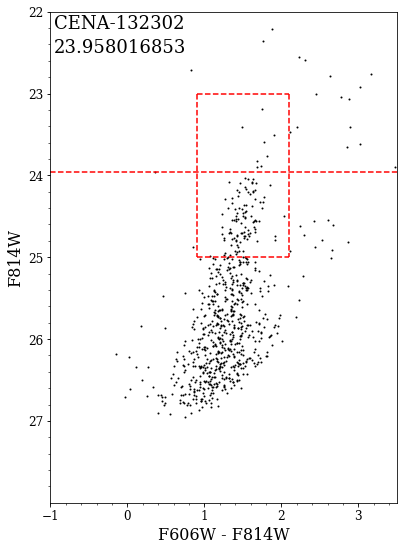

In [20]:
#CMD with boxed region
plt.rc('font',family='serif')
plt.rc('xtick',labelsize='12')
plt.rc('ytick',labelsize='12')
cmd = plt.figure(figsize=(6,8))
ax = cmd.add_subplot(1,1,1)
ax.plot(realV-realI, realI,'o',markersize=1, color='black')

ax.plot( [ PLT['cl'], PLT['cl']], [PLT['ml'], PLT['mh'] ] , '--', color='red')
ax.plot( [ PLT['ch'], PLT['ch']], [PLT['ml'], PLT['mh'] ] , '--', color='red')
ax.plot( [ PLT['cl'], PLT['ch']], [PLT['ml'], PLT['ml'] ] , '--', color='red')
ax.plot( [ PLT['cl'], PLT['ch']], [PLT['mh'], PLT['mh'] ] , '--', color='red')

plt.axhline(y=BFIT[3], color='r', linestyle='--')

xMajorTicks = np.arange(-1, 3.5, 1.0)                                              
xMinorTicks = np.arange(-1, 3.5, 0.2)     
yMajorTicks = np.arange(22, 28, 1.0)                                              
yMinorTicks = np.arange(22, 28, 0.2)     

ax.set_xticks(xMajorTicks)                                                       
ax.set_xticks(xMinorTicks, minor=True)                                           
ax.set_yticks(yMajorTicks)                                                       
ax.set_yticks(yMinorTicks, minor=True)   

ax.set_xlabel("%s - %s" %(band1,band2), fontsize=16)
ax.set_ylabel(band2, fontsize=16)

ax.set_xlim((-1,3.5))
ax.set_ylim((28,22))

ax.annotate(prefix,xy=(-0.95,22.2))
ax.annotate(BFIT[3],xy=(-0.95,22.5))
cmd.tight_layout()
plt.savefig('%scmd_final.ps' %prefix, dpi=300)